In [1]:
import pandas as pd
import warnings

def data_loading(file):
    return pd.read_csv(file)

def data_clean(dt_df):
    print(dt_df.head()) # print the top 4 rows of the dataset
    before=dt_df.shape
    print(dt_df.dtypes)
    print(dt_df.isnull().sum())
    dt_df = dt_df.dropna() # this is to drop Null values if any
    print(dt_df.duplicated().sum()) # print duplicate
    dt_df = dt_df.drop_duplicates()
    after=dt_df.shape
    print("shape of the dataset before removing null and duplicates"+str(before)) 
    print("shape of the dataset after removing null and duplicates"+str(after))
    return dt_df

def create_new_file_ids(dt_df):
    import pandas as pd
    return dt_df.to_csv("ids_clean.csv")

# Custom Label Encoder for handling unknown values
import numpy as np

def label_encode_category(xtrain,xtest):
    xtrain_encode=xtrain
    xtest_encode=xtest
    label_ext_train=list(xtrain_encode.select_dtypes(include=['object']).columns).copy()
    label_ext_test=list(xtest_encode.select_dtypes(include=['object']).columns).copy()
    
    for i in label_ext_train:
        xtrain_encode[i]=xtrain_encode[i].astype('category')
        xtrain_encode[i]=xtrain_encode[i].cat.codes
    for i in label_ext_test:
        xtest_encode[i]=xtest_encode[i].astype('category')
        xtest_encode[i]=xtest_encode[i].cat.codes
    
    return xtrain_encode,xtest_encode

def label_encode_smote(x):
    from sklearn.preprocessing import LabelEncoder
    enc=LabelEncoder()
    x_smote=x
    label_ext_x_smote=x_smote.select_dtypes(include=['object']).copy()
   
    for i in label_ext_x_smote:
        x_smote[i]=enc.fit_transform(x_smote[i])
    
    return x_smote

def Scaling(xtrain,xtest):
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
        # store the columns
    cols = xtrain.columns

        # transform the data
    xtrain_scaled = scaler.fit_transform(xtrain)
    xtest_scaled = scaler.fit_transform(xtest)

    xtrain_scaled = pd.DataFrame(xtrain_scaled, columns = cols)
    xtest_scaled = pd.DataFrame(xtest_scaled, columns = cols)
    
    print("normalize values of the xtrain")
    print(xtrain_scaled.head())
    print("normalize values of the xtest")
    print(xtest_scaled.head())
    
    return xtrain_scaled,xtest_scaled


def exploration_Analysis(data):
    import matplotlib.pyplot as plt
    import seaborn as sns
    corr = data.corr()
    plt.figure(figsize =(15, 12))
    sns.heatmap(corr)
    plt.show()
    sns.countplot(data['class']) #plotting class data
    plt.show()
    sns.countplot(data['protocol_type'])# plotting protocol data
    plt.show()
    sns.countplot(data['protocol_type'],hue=df['class']) # protocol with respect to class
    plt.show()
    sns.countplot(data['flag']) # plotting flag data
    plt.show()
    sns.countplot(data['flag'], hue=df['class']) # flag with respect to class
    plt.show()
    plt.figure(figsize =(9, 9))
    data['class'].value_counts().plot.pie()
    plt.show()
    plt.figure(figsize =(10, 10))
    data['flag'].value_counts().plot.pie()
    plt.show()
    plt.figure(figsize =(9, 9))
    data['service'].value_counts().plot.pie()
    plt.show()
    return data

def Gradient_boost(xtrain_scaled,ytrain):
    from sklearn.ensemble import GradientBoostingClassifier
    gbc = GradientBoostingClassifier();

    gbc.fit(xtrain_scaled, ytrain)

    feat_imp = pd.DataFrame({'feature':xtrain.columns,'importance':gbc.feature_importances_})
    feat_imp = feat_imp.sort_values('importance',ascending=False).set_index('feature')
    print(feat_imp)
    
def rfe_GboostClf(xtrain_scaled,xtest_scaled,xtrain,ytrain):
    import itertools
    from sklearn.ensemble import GradientBoostingClassifier
    from sklearn.feature_selection import RFE
    estim_gb=GradientBoostingClassifier()
    estim_select_gb=RFE(estim_gb)
    print("xtrain_scaled shape before RFE using Gradient Boost:",(xtrain_scaled).shape)
    print("xtest_scaled shape before RFE using Gradient Boost:",(xtest_scaled).shape)
    estim_select_gb.fit(xtrain_scaled,ytrain)
    print("xtrain_scaled shape after RFE using Gradient Boost:",estim_select_gb.transform(xtrain_scaled).shape)
    print("xtest_scaled shape after RFE using Gradient Boost:",estim_select_gb.transform(xtest_scaled).shape)
    print("xtrain_scaled",estim_select_gb.transform(xtrain_scaled))
    print("xtest_scaled",estim_select_gb.transform(xtest_scaled))
    xtrain_scaled = estim_select_gb.transform(xtrain_scaled)
    xtest_scaled = estim_select_gb.transform(xtest_scaled)
    features = [(i, v) for i, v in itertools.zip_longest(estim_select_gb.get_support(), xtrain.columns)]
    selected_features = [v for i, v in features if i==True]
    print("Selected Features are:","\n",selected_features)
    return xtrain_scaled,xtest_scaled

def model_building(xtrain_scaled, ytrain):
    import warnings
    from sklearn.svm import SVC
    from sklearn.linear_model import LogisticRegression
    from sklearn.naive_bayes import BernoulliNB 
    from lightgbm import LGBMClassifier
    from xgboost import XGBClassifier
    from sklearn.ensemble import GradientBoostingClassifier
    from sklearn.cluster import KMeans
    
    from sklearn.tree import ExtraTreeClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.neighbors import RadiusNeighborsClassifier
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.model_selection import cross_val_score
    from sklearn.metrics import confusion_matrix, classification_report, f1_score

    SEED=40
    svc = SVC(random_state=SEED)

    # LogisticRegression Model
    lr = LogisticRegression()

    # Gaussian Naive Bayes Model
    bnb = BernoulliNB()

    # Train XGBoost Classifier
    xgbc = XGBClassifier(eval_metric="logloss", random_state=SEED)

    # Train LightGBM Classifier
    lgbmc = LGBMClassifier(random_state=SEED)

    # Train Gradient Boosting Classifier 
    GB = GradientBoostingClassifier(random_state=SEED)
    
    # train Extra Tree Classifier
    ET=ExtraTreeClassifier(random_state=SEED)
    
    # train Decision Tree Classifier
    DT=DecisionTreeClassifier(random_state=SEED)
    
    # KNeighbors Classifier
    KN=KNeighborsClassifier(n_neighbors=5)
    
    
    
    models_set={}
    models_set['SVC']= svc
    models_set['LogisticRegression']= lr
    models_set['Naive Bayes Classifier']= bnb
    models_set['XGBoost Classifier']= xgbc
    models_set['LightGBM Classifier']= lgbmc
    models_set['Gradient Boosting']=GB
    models_set['Extra Tree Classifier']= ET
    models_set['Decision Tree Classifier']=DT
    models_set['KNeighbors Classifier']=KN



    scores = {}
    for models in models_set:
        scores[models]={}
        for scorer in ['precision','recall']:
            scores[models][scorer] = cross_val_score(models_set[models], xtrain_scaled, ytrain, cv=10, scoring=scorer)
            warnings.simplefilter(action="ignore")
            
    for models in models_set:
        print(line(models), models, 'Model Validation', line(models))
        for scorer in ['precision','recall']:
            mean = round(np.mean(scores[models][scorer])*100,2)
            stdev = round(np.std(scores[models][scorer])*100,2)
            print ("Mean {}:".format(scorer),"\n", mean,"%", "+-",stdev)
            
    return scores,models_set

def Prediction_train_data(xtrain_scaled,ytrain,models_set):
    from sklearn.metrics import confusion_matrix, classification_report, f1_score
    print("The reason for predicting on train dataset is to check the overfitting on the test dataset")
    print("predicting the train data")
    preds={}
    for models in models_set:
        models_set[models].fit(xtrain_scaled, ytrain)
        preds[models] = models_set[models].predict(xtrain_scaled)
    print("Train data Predictions complete.")
    for models in models_set:
        print(line(models), models, 'Model Testing for training data set', line(models))
        print(confusion_matrix(ytrain, preds[models]))
        print(line(models,'-'))
        print(classification_report(ytrain, preds[models], target_names=["normal","anamoly"]))
        
def Prediction_test_data(xtest_scaled,ytest,models_set):
    from sklearn.metrics import confusion_matrix, classification_report, f1_score
    print("predicting the test data")
    preds={}
    for models in models_set:
        models_set[models].fit(xtest_scaled, ytest)
        preds[models] = models_set[models].predict(xtest_scaled)
    print("Train data Predictions complete.")
    for models in models_set:
        print(line(models), models, 'Model Testing for training data set', line(models))
        print(confusion_matrix(ytest, preds[models]))
        print(line(models,'-'))
        print(classification_report(ytest, preds[models], target_names=["normal","anamoly"]))
        
def line(name,sym="*"):
        return sym*(25-len(name)//2)
        print("data accuracy")
        

In [2]:
df=data_loading("ids.csv")

In [3]:
df=data_clean(df)

   duration protocol_type   service  flag  src_bytes  dst_bytes  land  \
0         0           tcp   private   REJ        0.0        0.0     0   
1         0           tcp   private   REJ        0.0        0.0     0   
2         2           tcp  ftp_data    SF    12983.0        0.0     0   
3         0          icmp     eco_i    SF       20.0        0.0     0   
4         1           tcp    telnet  RSTO        0.0       15.0     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  10   
1               0       0    0  ...                   1   
2               0       0    0  ...                  86   
3               0       0    0  ...                  57   
4               0       0    0  ...                  86   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.04                    0.06   
1                    0.00                    0.06   
2                    0.61                    0.

In [4]:
create_new_file_ids(df)

# Data Exploration

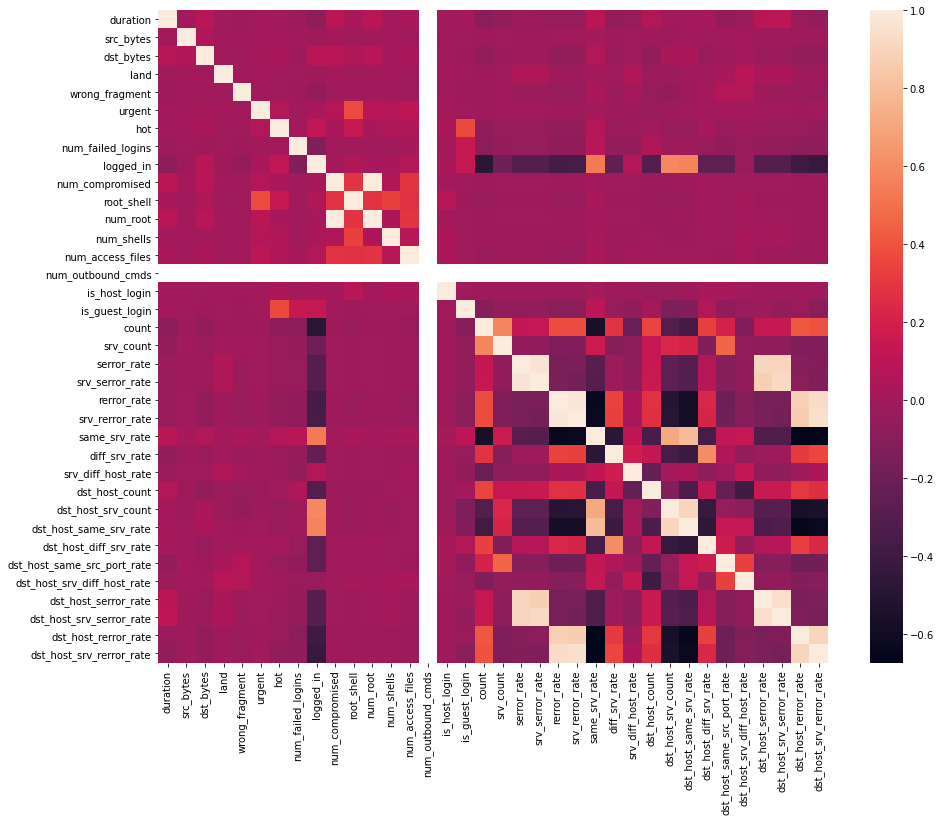

c:\users\pavan k m\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


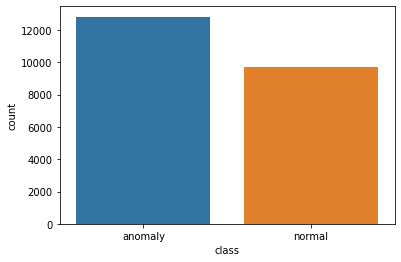

c:\users\pavan k m\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


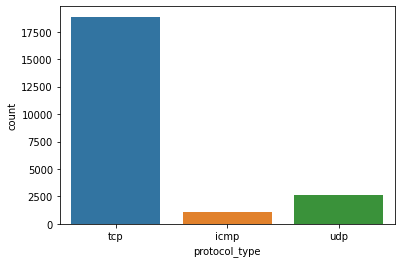

c:\users\pavan k m\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


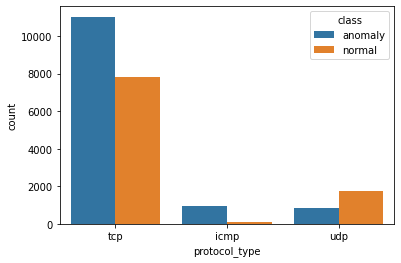

c:\users\pavan k m\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


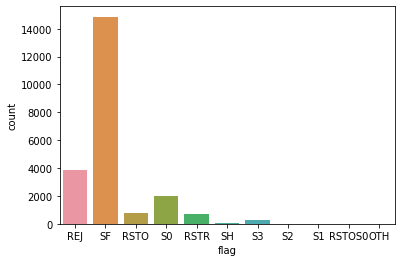

c:\users\pavan k m\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


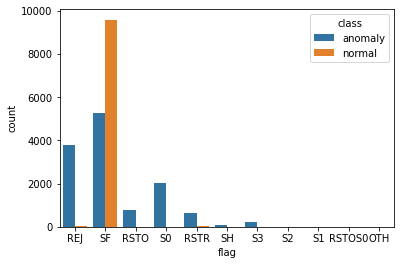

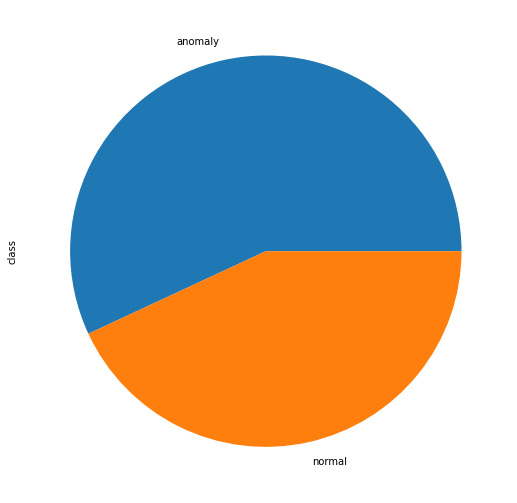

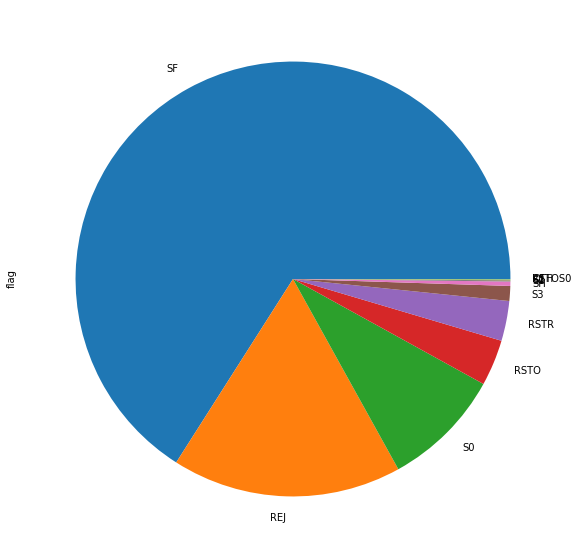

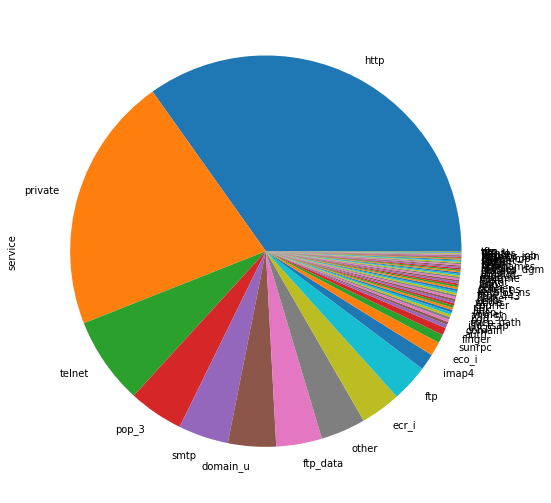

In [5]:
df=exploration_Analysis(df)

##### We found that their is imbalance of sample on target data

In [6]:
df['class'].value_counts()

anomaly    12824
normal      9702
Name: class, dtype: int64

##### We are doing oversampling to balance the data using SMOTE and Random Sampling after the analysis of the actual data

#### tain test split

In [7]:
from sklearn.model_selection import train_test_split

x=df.drop(columns=['class'])
y=df['class']

xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.3)

In [8]:
# Encoding target class to 0 and 1

ytrain=ytrain.astype('category')
ytrain=ytrain.cat.codes

ytest=ytest.astype('category')
ytest=ytest.cat.codes

In [9]:
ytrain

15966    1
6387     1
3649     0
2109     0
21899    1
        ..
13583    0
16126    0
16779    0
1726     0
9084     0
Length: 15768, dtype: int8

In [10]:
ytest

6812     0
15116    0
20421    1
9470     1
13199    1
        ..
17079    0
16790    0
2407     0
3502     0
11526    1
Length: 6758, dtype: int8

##### Encoding target class to 0 and 1

In [11]:
import warnings
xtrain,xtest=label_encode_category(xtrain,xtest)
warnings.simplefilter(action='ignore')

C:\Users\PAVANK~1\AppData\Local\Temp/ipykernel_3700/2383259375.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xtrain_encode[i]=xtrain_encode[i].astype('category')
C:\Users\PAVANK~1\AppData\Local\Temp/ipykernel_3700/2383259375.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xtrain_encode[i]=xtrain_encode[i].cat.codes
C:\Users\PAVANK~1\AppData\Local\Temp/ipykernel_3700/2383259375.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [12]:
xtrain

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
15966,0,1,22,8,178.0,27295.0,0,0,0,0,...,27,255,1.00,0.00,0.04,0.04,0.00,0.00,0.00,0.00
6387,1,1,49,8,7184.0,338.0,0,0,0,0,...,255,164,0.64,0.03,0.00,0.00,0.00,0.00,0.13,0.00
3649,0,1,55,4,0.0,0.0,0,0,0,0,...,255,243,0.95,0.03,0.00,0.00,0.95,1.00,0.00,0.00
2109,3,1,24,2,0.0,44.0,0,0,0,0,...,255,23,0.09,0.03,0.00,0.00,0.00,0.00,0.30,0.96
21899,0,2,45,8,52.0,53.0,0,0,0,0,...,255,255,1.00,0.00,0.83,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13583,0,1,40,1,0.0,0.0,0,0,0,0,...,255,1,0.00,1.00,0.00,0.00,0.03,0.00,0.95,1.00
16126,0,1,45,1,0.0,0.0,0,0,0,0,...,255,3,0.01,0.07,0.00,0.00,0.00,0.00,1.00,1.00
16779,7370,1,55,8,0.0,44.0,0,0,0,0,...,255,214,0.84,0.16,0.00,0.00,0.50,0.59,0.16,0.01
1726,0,2,45,8,47.0,0.0,0,0,0,0,...,255,254,1.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00


In [13]:
xtest

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
6812,0,1,45,1,0.0,0.0,0,0,0,0,...,255,3,0.01,0.07,0.00,0.00,0.00,0.00,1.00,1.0
15116,0,1,40,1,0.0,0.0,0,0,0,0,...,255,1,0.00,1.00,0.01,0.00,0.06,0.00,0.94,1.0
20421,0,1,22,9,346.0,468.0,0,0,0,0,...,187,255,1.00,0.00,0.01,0.01,0.00,0.00,0.00,0.0
9470,0,1,19,9,59.0,0.0,0,0,0,0,...,26,72,0.85,0.15,0.85,0.04,0.00,0.01,0.00,0.0
13199,0,1,19,9,2409.0,0.0,0,0,0,0,...,169,39,0.21,0.04,0.21,0.05,0.00,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17079,0,1,40,1,0.0,0.0,0,0,0,0,...,255,5,0.02,0.02,0.00,0.00,0.00,0.00,0.02,1.0
16790,0,1,45,5,0.0,0.0,0,0,0,0,...,255,11,0.04,0.06,0.00,0.00,1.00,1.00,0.00,0.0
2407,0,1,45,1,0.0,0.0,0,0,0,0,...,255,7,0.03,0.06,0.00,0.00,0.00,0.00,1.00,1.0
3502,0,1,10,1,0.0,0.0,0,0,0,0,...,255,18,0.07,0.05,0.00,0.00,0.00,0.00,1.00,1.0


# Scaling in the data

In [14]:
xtrain_scaled,xtest_scaled=Scaling(xtrain,xtest)

normalize values of the xtrain
   duration  protocol_type   service      flag  src_bytes  dst_bytes     land  \
0 -0.158411      -0.171251 -0.671441  0.670395  -0.031817   1.329598 -0.01781   
1 -0.157686      -0.171251  1.215002  0.670395  -0.005111  -0.084459 -0.01781   
2 -0.158411      -0.171251  1.634212 -0.732636  -0.032495  -0.102189 -0.01781   
3 -0.156235      -0.171251 -0.531704 -1.434151  -0.032495  -0.099881 -0.01781   
4 -0.158411       2.347671  0.935529  0.670395  -0.032297  -0.099409 -0.01781   

   wrong_fragment    urgent       hot  ...  dst_host_count  \
0       -0.057298 -0.019928 -0.167288  ...       -1.787146   
1       -0.057298 -0.019928 -0.167288  ...        0.646810   
2       -0.057298 -0.019928 -0.167288  ...        0.646810   
3       -0.057298 -0.019928 -0.167288  ...        0.646810   
4       -0.057298 -0.019928 -0.167288  ...        0.646810   

   dst_host_srv_count  dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0            1.018435               

In [15]:
xtrain_scaled

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,-0.158411,-0.171251,-0.671441,0.670395,-0.031817,1.329598,-0.01781,-0.057298,-0.019928,-0.167288,...,-1.787146,1.018435,0.895388,-0.409827,-0.299910,0.249260,-0.355591,-0.349879,-0.602181,-0.564585
1,-0.157686,-0.171251,1.215002,0.670395,-0.005111,-0.084459,-0.01781,-0.057298,-0.019928,-0.167288,...,0.646810,0.202527,0.067171,-0.274011,-0.430535,-0.227751,-0.355591,-0.349879,-0.266097,-0.564585
2,-0.158411,-0.171251,1.634212,-0.732636,-0.032495,-0.102189,-0.01781,-0.057298,-0.019928,-0.167288,...,0.646810,0.910843,0.780357,-0.274011,-0.430535,-0.227751,3.149750,3.225922,-0.602181,-0.564585
3,-0.156235,-0.171251,-0.531704,-1.434151,-0.032495,-0.099881,-0.01781,-0.057298,-0.019928,-0.167288,...,0.646810,-1.061681,-1.198160,-0.274011,-0.430535,-0.227751,-0.355591,-0.349879,0.173397,1.831579
4,-0.158411,2.347671,0.935529,0.670395,-0.032297,-0.099409,-0.01781,-0.057298,-0.019928,-0.167288,...,0.646810,1.018435,0.895388,-0.409827,2.279933,-0.227751,-0.355591,-0.349879,-0.602181,-0.564585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15763,-0.158411,-0.171251,0.586188,-1.784909,-0.032495,-0.102189,-0.01781,-0.057298,-0.019928,-0.167288,...,0.646810,-1.258933,-1.405214,4.117394,-0.430535,-0.227751,-0.244896,-0.349879,1.853815,1.931420
15764,-0.158411,-0.171251,0.935529,-1.784909,-0.032495,-0.102189,-0.01781,-0.057298,-0.019928,-0.167288,...,0.646810,-1.241001,-1.382208,-0.092922,-0.430535,-0.227751,-0.355591,-0.349879,1.983077,1.931420
15765,5.188235,-0.171251,1.634212,0.670395,-0.032495,-0.099881,-0.01781,-0.057298,-0.019928,-0.167288,...,0.646810,0.650828,0.527291,0.314528,-0.430535,-0.227751,1.489325,1.759843,-0.188540,-0.539625
15766,-0.158411,2.347671,0.935529,0.670395,-0.032316,-0.102189,-0.01781,-0.057298,-0.019928,-0.167288,...,0.646810,1.009469,0.895388,-0.364555,-0.430535,-0.227751,-0.355591,-0.349879,-0.602181,-0.564585


In [16]:
xtest_scaled

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,-0.149696,-0.187917,0.932199,-1.826701,-0.019322,-0.090082,-0.017206,-0.063204,-0.021074,-0.084363,...,0.658288,-1.212192,-1.355836,-0.092022,-0.434854,-0.235218,-0.364186,-0.359659,1.972274,1.923930
1,-0.149696,-0.187917,0.582626,-1.826701,-0.019322,-0.090082,-0.017206,-0.063204,-0.021074,-0.084363,...,0.658288,-1.229997,-1.378672,4.145629,-0.402194,-0.235218,-0.148423,-0.359659,1.817690,1.923930
2,-0.149696,-0.187917,-0.675838,0.669855,-0.018870,-0.071778,-0.017206,-0.063204,-0.021074,-0.084363,...,-0.058464,1.031212,0.904911,-0.410985,-0.402194,-0.122799,-0.364186,-0.359659,-0.604128,-0.567623
3,-0.149696,-0.187917,-0.885582,0.669855,-0.019245,-0.090082,-0.017206,-0.063204,-0.021074,-0.084363,...,-1.755481,-0.597927,0.562374,0.272507,2.341242,0.214457,-0.364186,-0.324818,-0.604128,-0.567623
4,-0.149696,-0.187917,-0.885582,0.669855,-0.016173,-0.090082,-0.017206,-0.063204,-0.021074,-0.084363,...,-0.248192,-0.891706,-0.899119,-0.228721,0.251005,0.326876,-0.364186,-0.359659,-0.604128,-0.567623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6753,-0.149696,-0.187917,0.582626,-1.826701,-0.019322,-0.090082,-0.017206,-0.063204,-0.021074,-0.084363,...,0.658288,-1.194387,-1.333000,-0.319853,-0.434854,-0.235218,-0.364186,-0.359659,-0.552600,1.923930
6754,-0.149696,-0.187917,0.932199,-0.578423,-0.019322,-0.090082,-0.017206,-0.063204,-0.021074,-0.084363,...,0.658288,-1.140973,-1.287328,-0.137588,-0.434854,-0.235218,3.231860,3.124488,-0.604128,-0.567623
6755,-0.149696,-0.187917,0.932199,-1.826701,-0.019322,-0.090082,-0.017206,-0.063204,-0.021074,-0.084363,...,0.658288,-1.176582,-1.310164,-0.137588,-0.434854,-0.235218,-0.364186,-0.359659,1.972274,1.923930
6756,-0.149696,-0.187917,-1.514815,-1.826701,-0.019322,-0.090082,-0.017206,-0.063204,-0.021074,-0.084363,...,0.658288,-1.078656,-1.218821,-0.183155,-0.434854,-0.235218,-0.364186,-0.359659,1.972274,1.923930


# Feature selection

In [17]:
Gradient_boost(xtrain_scaled,ytrain)

                             importance
feature                                
src_bytes                      0.416914
dst_bytes                      0.204122
duration                       0.064757
dst_host_rerror_rate           0.064174
protocol_type                  0.052746
hot                            0.046437
srv_count                      0.023980
service                        0.022673
dst_host_same_src_port_rate    0.021679
dst_host_srv_count             0.014896
dst_host_srv_rerror_rate       0.014157
count                          0.013418
dst_host_count                 0.005803
num_failed_logins              0.005795
dst_host_same_srv_rate         0.005369
srv_diff_host_rate             0.005367
dst_host_diff_srv_rate         0.004755
flag                           0.004074
dst_host_srv_diff_host_rate    0.003014
logged_in                      0.001625
num_root                       0.001161
rerror_rate                    0.000712
dst_host_srv_serror_rate       0.000494


In [18]:
xtrain_scaled,xtest_scaled=rfe_GboostClf(xtrain_scaled,xtest_scaled,xtrain,ytrain)

xtrain_scaled shape before RFE using Gradient Boost: (15768, 39)
xtest_scaled shape before RFE using Gradient Boost: (6758, 39)
xtrain_scaled shape after RFE using Gradient Boost: (15768, 19)
xtest_scaled shape after RFE using Gradient Boost: (6758, 19)
xtrain_scaled [[-0.15841129 -0.1712509  -0.67144061 ...  0.24926048 -0.60218092
  -0.56458487]
 [-0.15768583 -0.1712509   1.21500212 ... -0.22775138 -0.26609733
  -0.56458487]
 [-0.15841129 -0.1712509   1.63421161 ... -0.22775138 -0.60218092
  -0.56458487]
 ...
 [ 5.18823533 -0.1712509   1.63421161 ... -0.22775138 -0.18853958
  -0.53962482]
 [-0.15841129  2.34767093  0.93552912 ... -0.22775138 -0.60218092
  -0.56458487]
 [-0.15841129 -0.1712509   0.93552912 ... -0.22775138  1.98307749
   1.93141956]]
xtest_scaled [[-0.14969585 -0.18791716  0.93219918 ... -0.2352175   1.97227443
   1.92393037]
 [-0.14969585 -0.18791716  0.58262578 ... -0.2352175   1.8176903
   1.92393037]
 [-0.14969585 -0.18791716 -0.67583846 ... -0.12279884 -0.60412782


In [19]:
print(xtrain_scaled)

[[-0.15841129 -0.1712509  -0.67144061 ...  0.24926048 -0.60218092
  -0.56458487]
 [-0.15768583 -0.1712509   1.21500212 ... -0.22775138 -0.26609733
  -0.56458487]
 [-0.15841129 -0.1712509   1.63421161 ... -0.22775138 -0.60218092
  -0.56458487]
 ...
 [ 5.18823533 -0.1712509   1.63421161 ... -0.22775138 -0.18853958
  -0.53962482]
 [-0.15841129  2.34767093  0.93552912 ... -0.22775138 -0.60218092
  -0.56458487]
 [-0.15841129 -0.1712509   0.93552912 ... -0.22775138  1.98307749
   1.93141956]]


In [20]:
print(xtest_scaled)

[[-0.14969585 -0.18791716  0.93219918 ... -0.2352175   1.97227443
   1.92393037]
 [-0.14969585 -0.18791716  0.58262578 ... -0.2352175   1.8176903
   1.92393037]
 [-0.14969585 -0.18791716 -0.67583846 ... -0.12279884 -0.60412782
  -0.56762287]
 ...
 [-0.14969585 -0.18791716  0.93219918 ... -0.2352175   1.97227443
   1.92393037]
 [-0.14969585 -0.18791716 -1.51481462 ... -0.2352175   1.97227443
   1.92393037]
 [-0.14969585  2.33181338  0.93219918 ... -0.2352175  -0.60412782
  -0.56762287]]


# Model Building

#### On target variable we can see that we have less data for normal but still we can proceed and build the model but in the later section i will use SMOTE for oversampling to balence the data 

In [21]:
def line(name,sym="*"):
        return sym*(25-len(name)//2)
        print("data accuracy")

In [22]:
scores={}
model_set={}
scores,model_set=model_building(xtrain_scaled, ytrain)

************************ SVC Model Validation ************************
Mean precision: 
 97.71 % +- 0.34
Mean recall: 
 93.41 % +- 0.86
**************** LogisticRegression Model Validation ****************
Mean precision: 
 90.97 % +- 0.99
Mean recall: 
 92.37 % +- 0.83
************** Naive Bayes Classifier Model Validation **************
Mean precision: 
 76.62 % +- 1.38
Mean recall: 
 92.03 % +- 0.83
**************** XGBoost Classifier Model Validation ****************
Mean precision: 
 98.57 % +- 0.56
Mean recall: 
 98.64 % +- 0.45
**************** LightGBM Classifier Model Validation ****************
Mean precision: 
 98.65 % +- 0.48
Mean recall: 
 98.53 % +- 0.41
***************** Gradient Boosting Model Validation *****************
Mean precision: 
 98.04 % +- 0.64
Mean recall: 
 96.7 % +- 0.63
*************** Extra Tree Classifier Model Validation ***************
Mean precision: 
 97.43 % +- 0.22
Mean recall: 
 96.92 % +- 0.47
************* Decision Tree Classifier Model Validat

In [23]:
Prediction_train_data(xtrain_scaled,ytrain,model_set)

The reason for predicting on train dataset is to check the overfitting on the test dataset
predicting the train data
Train data Predictions complete.
************************ SVC Model Testing for training data set ************************
[[8833  121]
 [ 419 6395]]
------------------------
              precision    recall  f1-score   support

      normal       0.95      0.99      0.97      8954
     anamoly       0.98      0.94      0.96      6814

    accuracy                           0.97     15768
   macro avg       0.97      0.96      0.96     15768
weighted avg       0.97      0.97      0.97     15768

**************** LogisticRegression Model Testing for training data set ****************
[[8330  624]
 [ 520 6294]]
----------------
              precision    recall  f1-score   support

      normal       0.94      0.93      0.94      8954
     anamoly       0.91      0.92      0.92      6814

    accuracy                           0.93     15768
   macro avg       0.93      0

In [24]:
Prediction_test_data(xtest_scaled,ytest,model_set)

predicting the test data
Train data Predictions complete.
************************ SVC Model Testing for training data set ************************
[[3816   54]
 [ 204 2684]]
------------------------
              precision    recall  f1-score   support

      normal       0.95      0.99      0.97      3870
     anamoly       0.98      0.93      0.95      2888

    accuracy                           0.96      6758
   macro avg       0.96      0.96      0.96      6758
weighted avg       0.96      0.96      0.96      6758

**************** LogisticRegression Model Testing for training data set ****************
[[3499  371]
 [ 249 2639]]
----------------
              precision    recall  f1-score   support

      normal       0.93      0.90      0.92      3870
     anamoly       0.88      0.91      0.89      2888

    accuracy                           0.91      6758
   macro avg       0.91      0.91      0.91      6758
weighted avg       0.91      0.91      0.91      6758

*************

In [40]:
scores

{'SVC': {'precision': array([0.97420334, 0.9844479 , 0.97674419, 0.97839506, 0.98159509,
         0.97507788, 0.97699387, 0.97243492, 0.97727273, 0.97424242]),
  'recall': array([0.94134897, 0.92815249, 0.92375367, 0.92961877, 0.93979442,
         0.91923642, 0.93538913, 0.93245228, 0.94713656, 0.94419971])},
 'LogisticRegression': {'precision': array([0.91532847, 0.92047128, 0.90497076, 0.92105263, 0.91066282,
         0.91508053, 0.89857143, 0.88904494, 0.91798561, 0.90340909]),
  'recall': array([0.91935484, 0.91642229, 0.90762463, 0.92375367, 0.92804699,
         0.91776799, 0.9236417 , 0.92951542, 0.93685756, 0.9339207 ])},
 'Naive Bayes Classifier': {'precision': array([0.78039702, 0.77915633, 0.76913425, 0.74850299, 0.79      ,
         0.77447336, 0.75118483, 0.7508982 , 0.76242424, 0.75600962]),
  'recall': array([0.92228739, 0.92082111, 0.89882698, 0.91642229, 0.92804699,
         0.91776799, 0.93098385, 0.92070485, 0.9236417 , 0.9236417 ])},
 'XGBoost Classifier': {'precisio

## Oversampling the data

In [25]:
from imblearn.over_sampling import RandomOverSampler
x_rand,y_rand=RandomOverSampler().fit_resample(x,y) # Random Sampler

#### for SMOTE sampler we need to label encode the data, because it wont accept object types data

In [26]:
from imblearn.over_sampling import SMOTE # SMOTE Sampler

x_smote=label_encode_smote(x)

# Encoding target class to 0 and 1
y_smote = y.apply(lambda x: 1 if x=="anomaly" else 0)

x_smote,y_smote=SMOTE().fit_resample(x_smote,y_smote)

#### After Oversampling of Random and SMOTE Sampler

In [27]:
print("SMOTE 0=normal, 1= anomaly","\n",y_smote.value_counts())

SMOTE 0=normal, 1= anomaly 
 0    12824
1    12824
Name: class, dtype: int64


In [28]:
print(y_rand.value_counts())

anomaly    12824
normal     12824
Name: class, dtype: int64


#### Data Split for the oversampled variables

In [29]:
from sklearn.model_selection import train_test_split

xtrain_rand,xtest_rand,ytrain_rand,ytest_rand=train_test_split(x_rand,y_rand,test_size=0.3)
xtrain_smote,xtest_smote,ytrain_smote,ytest_smote=train_test_split(x_smote,y_smote,test_size=0.3)

##### Encoding target class to 0 and 1 for random sampler

In [30]:
ytrain_rand=ytrain_rand.astype('category')
ytrain_rand=ytrain_rand.cat.codes

ytest_rand=ytest_rand.astype('category')
ytest_rand=ytest_rand.cat.codes

In [31]:
ytest_rand

9277     0
24677    1
17249    1
21764    0
17925    1
        ..
1739     1
18309    0
5556     0
3145     1
14147    1
Length: 7695, dtype: int8

#### We see that SMOTE values are already label encoded lets apply label encoding on Random Sapler data

In [32]:
xtrain_rand,xtest_rand=label_encode_category(xtrain_rand,xtest_rand)

### Scaling the SMOTE and Rand sample variables

In [33]:
print("Random Sampler data")
xtrain_scaled_rand,xtest_scaled_rand=Scaling(xtrain_rand,xtest_rand)
print("SMOTE data")
xtrain_scaled_smote,xtest_scaled_smote=Scaling(xtrain_smote,xtest_smote)

Random Sampler data
normalize values of the xtrain
   duration  protocol_type   service      flag  src_bytes  dst_bytes  \
0 -0.158826      -2.710919 -1.190278  0.604209  -0.019238  -0.091471   
1 -0.158826      -0.202718 -0.622018  0.604209  -0.020798  -0.069079   
2 -0.158826      -0.202718 -0.622018  0.604209  -0.020598   0.076924   
3 -0.158826      -0.202718  1.722054  0.280001  -0.021185  -0.089818   
4 -0.158826      -0.202718  1.722054  0.604209  -0.020955  -0.084934   

       land  wrong_fragment    urgent       hot  ...  dst_host_count  \
0 -0.016691       -0.062463 -0.019408 -0.100147  ...        0.683443   
1 -0.016691       -0.062463 -0.019408 -0.100147  ...       -1.795288   
2 -0.016691       -0.062463 -0.019408 -0.100147  ...       -1.805703   
3 -0.016691       -0.062463 -0.019408 -0.100147  ...        0.683443   
4 -0.016691       -0.062463 -0.019408 -0.100147  ...        0.683443   

   dst_host_srv_count  dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0         

#### Feature extraction and selection for the oversampled data

In [34]:
print("gradient boost for random Sampler data")
Gradient_boost(xtrain_scaled_rand,ytrain_rand)
print("gradient boost for SMOTE Sampler data")
Gradient_boost(xtrain_scaled_smote,ytrain_smote)

gradient boost for random Sampler data
                             importance
feature                                
src_bytes                      0.376387
dst_bytes                      0.232935
duration                       0.070463
dst_host_rerror_rate           0.062798
protocol_type                  0.055312
hot                            0.044518
service                        0.027999
dst_host_same_src_port_rate    0.023338
dst_host_srv_count             0.018818
srv_count                      0.017993
count                          0.013627
num_failed_logins              0.010607
flag                           0.009642
dst_host_srv_rerror_rate       0.008837
dst_host_count                 0.006532
dst_host_same_srv_rate         0.006097
srv_diff_host_rate             0.004564
dst_host_srv_diff_host_rate    0.002345
logged_in                      0.002262
dst_host_diff_srv_rate         0.001404
is_guest_login                 0.000762
wrong_fragment                 0.000512
n

In [35]:
xtrain_scaled_rand,xtest_scaled_rand=rfe_GboostClf(xtrain_scaled_rand,xtest_scaled_rand,xtrain_rand,ytrain_rand)

print("RFE for the Random Sampler using Gradient Boost Completed")

xtrain_scaled_smote,xtest_scaled_smote=rfe_GboostClf(xtrain_scaled_smote,xtest_scaled_smote,xtrain_smote,ytrain_smote)

print("RFE for the SMOTE Sampler using Gradient Boost Completed")

xtrain_scaled shape before RFE using Gradient Boost: (17953, 39)
xtest_scaled shape before RFE using Gradient Boost: (7695, 39)
xtrain_scaled shape after RFE using Gradient Boost: (17953, 19)
xtest_scaled shape after RFE using Gradient Boost: (7695, 19)
xtrain_scaled [[-0.1588262  -2.71091895 -1.19027775 ... -0.24133061 -0.55794596
  -0.52023402]
 [-0.1588262  -0.20271817 -0.6220179  ...  0.26120473 -0.55794596
  -0.52023402]
 [-0.1588262  -0.20271817 -0.6220179  ...  0.38683857 -0.55794596
  -0.52023402]
 ...
 [-0.1588262  -0.20271817 -0.90614783 ... -0.24133061  2.13452612
   2.09362463]
 [-0.1588262  -0.20271817 -0.6220179  ...  0.00993706 -0.55794596
  -0.52023402]
 [-0.1588262  -0.20271817 -0.6220179  ... -0.24133061 -0.53102124
  -0.49409543]]
xtest_scaled [[-1.25294593e-01 -2.18713741e-01  9.76810454e-01 ... -2.33004178e-01
  -5.57038949e-01 -5.26777803e-01]
 [-1.25294593e-01  2.27462290e+00  9.76810454e-01 ... -2.33004178e-01
  -5.57038949e-01 -5.26777803e-01]
 [-1.25294593e-01

In [36]:
ytrain_smote

24542    0
16838    0
23661    0
1274     1
21087    1
        ..
23605    0
3827     0
14860    0
11153    1
1397     0
Name: class, Length: 17953, dtype: int64

#### Model bulding for the oversampled data

In [37]:
scores_rand={}
model_set_rand={}
scores_rand,model_set_rand=model_building(xtrain_scaled_rand, ytrain_rand)
print("model fitting completed for the Random sampled data")
scores_smote={}
model_set_smote={}
scores_smote,model_set_smote=model_building(xtrain_scaled_smote, ytrain_smote)
print("model fitting completed for the SMOTE sampled data")

************************ SVC Model Validation ************************
Mean precision: 
 97.73 % +- 0.46
Mean recall: 
 94.31 % +- 1.18
**************** LogisticRegression Model Validation ****************
Mean precision: 
 92.97 % +- 0.82
Mean recall: 
 92.85 % +- 0.88
************** Naive Bayes Classifier Model Validation **************
Mean precision: 
 81.43 % +- 1.08
Mean recall: 
 91.64 % +- 1.21
**************** XGBoost Classifier Model Validation ****************
Mean precision: 
 98.7 % +- 0.24
Mean recall: 
 98.99 % +- 0.41
**************** LightGBM Classifier Model Validation ****************
Mean precision: 
 98.65 % +- 0.14
Mean recall: 
 99.09 % +- 0.44
***************** Gradient Boosting Model Validation *****************
Mean precision: 
 97.9 % +- 0.41
Mean recall: 
 97.67 % +- 0.79
*************** Extra Tree Classifier Model Validation ***************
Mean precision: 
 97.96 % +- 0.5
Mean recall: 
 98.16 % +- 0.34
************* Decision Tree Classifier Model Validatio

#### Prediction for oversampled data

In [38]:
Prediction_train_data(xtrain_scaled_rand,ytrain_rand,model_set_rand)
print("train Prediction Completed for Random sampler") # training data prediction
Prediction_test_data(xtest_scaled_rand,ytest_rand,model_set_rand)
print("test Prediction Completed for Random sampler") # testing data prediction

The reason for predicting on train dataset is to check the overfitting on the test dataset
predicting the train data
Train data Predictions complete.
************************ SVC Model Testing for training data set ************************
[[8803  172]
 [ 480 8498]]
------------------------
              precision    recall  f1-score   support

      normal       0.95      0.98      0.96      8975
     anamoly       0.98      0.95      0.96      8978

    accuracy                           0.96     17953
   macro avg       0.96      0.96      0.96     17953
weighted avg       0.96      0.96      0.96     17953

**************** LogisticRegression Model Testing for training data set ****************
[[8342  633]
 [ 637 8341]]
----------------
              precision    recall  f1-score   support

      normal       0.93      0.93      0.93      8975
     anamoly       0.93      0.93      0.93      8978

    accuracy                           0.93     17953
   macro avg       0.93      0

In [39]:
Prediction_train_data(xtrain_scaled_smote,ytrain_smote,model_set_smote)
print("train Prediction Completed for SMOTE sampler")
Prediction_test_data(xtest_scaled_smote,ytest_smote,model_set_smote)
print("test Prediction Completed for SMOTE sampler")

The reason for predicting on train dataset is to check the overfitting on the test dataset
predicting the train data
Train data Predictions complete.
************************ SVC Model Testing for training data set ************************
[[8464  478]
 [ 167 8844]]
------------------------
              precision    recall  f1-score   support

      normal       0.98      0.95      0.96      8942
     anamoly       0.95      0.98      0.96      9011

    accuracy                           0.96     17953
   macro avg       0.96      0.96      0.96     17953
weighted avg       0.96      0.96      0.96     17953

**************** LogisticRegression Model Testing for training data set ****************
[[8334  608]
 [ 697 8314]]
----------------
              precision    recall  f1-score   support

      normal       0.92      0.93      0.93      8942
     anamoly       0.93      0.92      0.93      9011

    accuracy                           0.93     17953
   macro avg       0.93      0

              precision    recall  f1-score   support

      normal       1.00      1.00      1.00      3882
     anamoly       1.00      1.00      1.00      3813

    accuracy                           1.00      7695
   macro avg       1.00      1.00      1.00      7695
weighted avg       1.00      1.00      1.00      7695

*************** KNeighbors Classifier Model Testing for training data set ***************
[[3777  105]
 [  74 3739]]
---------------
              precision    recall  f1-score   support

      normal       0.98      0.97      0.98      3882
     anamoly       0.97      0.98      0.98      3813

    accuracy                           0.98      7695
   macro avg       0.98      0.98      0.98      7695
weighted avg       0.98      0.98      0.98      7695

************ RadiusNeighbors Classifier Model Testing for training data set ************
[[3755  127]
 [1698 2115]]
------------
              precision    recall  f1-score   support

      normal       0.69      